# Special Case: Inference with Forest-Guided Clustering

📚 In this tutorial, we explore how **Forest-Guided Clustering (FGC)** can be extended beyond training data to draw **meaningful inferences on unseen test data**. Typically, when training a Random Forest model, we split our dataset into a **training** and **test set** to assess the model's **generalization performance** usually through metrics like accuracy or R². However, performance metrics alone don’t tell the full story. They quantify how well the model predicts, but not **how well its learned structure and explanations transfer** to new data. FGC goes a step further: by analyzing the decision structure of the Random Forest, it enables us to check **whether the patterns discovered during training also hold for the test set**. This allows us to not only test the predictive power of our model, but also its **interpretability power**.

📦 **Installation:** To get started, you need to install the `fgclustering` package. Please follow the instructions on the [official installation guide](https://forest-guided-clustering.readthedocs.io/en/latest/_getting_started/installation.html).

🚧 **Note:** For a general introduction to FGC, please refer to our [Introduction Notebook](https://forest-guided-clustering.readthedocs.io/en/latest/_tutorials/introduction_to_FGC_use_cases.html).

**Imports:**

In [1]:
## Import the Forest-Guided Clustering package
from fgclustering import (
    forest_guided_clustering, 
    forest_guided_feature_importance, 
    plot_forest_guided_decision_paths, 
    DistanceRandomForestProximity, 
    ClusteringKMedoids,
)

## Imports for datasets
from sklearn.datasets import fetch_california_housing

## Additional imports for use-cases

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

## 🏠 The California Housing Dataset

To demonstrate how Forest-Guided Clustering (FGC) can be applied at inference time, we will again use the **California Housing dataset** (see *Use Case 3* for a detailed description). For this example, we will use the **first 1,000 samples** as our **training set**, on which we train a **Random Forest Regressor**. The model's hyperparameters, specifically `max_depth` and `max_features`, are tuned using **5-fold cross-validation** to balance performance and generalization.

In [2]:
data_housing = fetch_california_housing(as_frame=True).frame

data_housing_train = data_housing.iloc[:1000]
X_housing_train = data_housing_train.loc[:, data_housing_train.columns != 'MedHouseVal']
y_housing_train = data_housing_train.MedHouseVal

regressor = RandomForestRegressor(max_samples=0.8, bootstrap=True, oob_score=True, random_state=42)

grid = {'max_depth':[2, 5], 'max_features': ['sqrt', 'log2']}
grid_regressor = GridSearchCV(regressor, grid, cv=5)
grid_regressor.fit(X_housing_train, y_housing_train)
rf_housing = grid_regressor.best_estimator_

print(f'Parameters of best prediction model: {grid_regressor.best_params_}')
print(f'Train Set R^2 of prediction model: {round(rf_housing.score(X_housing_train, y_housing_train),3)}')

Parameters of best prediction model: {'max_depth': 5, 'max_features': 'log2'}
Train Set R^2 of prediction model: 0.826


## 🔍 Interpreting Test Set Behavior with Forest-Guided Clustering

To understand the relationship between **housing values** and the input features (e.g. median income, house age, etc.), we start by applying the **Forest-Guided Clustering (FGC)** method on the **training dataset** using the trained **Random Forest Regressor**.

Using a sample size of 80.0 % of the input data.
Using range k = (2, 6) to optimize k.


Optimizing k: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]



Optimal number of clusters k = 4

Clustering Evaluation Summary:
 k    Score  Stable  Mean_JI                                                   Cluster_JI
 2 0.726951    True    0.920                                         {1: 0.898, 2: 0.941}
 3      NaN   False    0.794                               {1: 0.929, 2: 0.662, 3: 0.792}
 4 0.423497    True    0.945                      {1: 0.909, 2: 0.953, 3: 0.968, 4: 0.95}
 5      NaN   False    0.855           {1: 0.944, 2: 0.837, 3: 0.696, 4: 0.915, 5: 0.881}
 6      NaN   False    0.835 {1: 0.806, 2: 0.832, 3: 0.907, 4: 0.891, 5: 0.862, 6: 0.712}


100%|██████████| 8/8 [00:00<00:00, 441.04it/s]


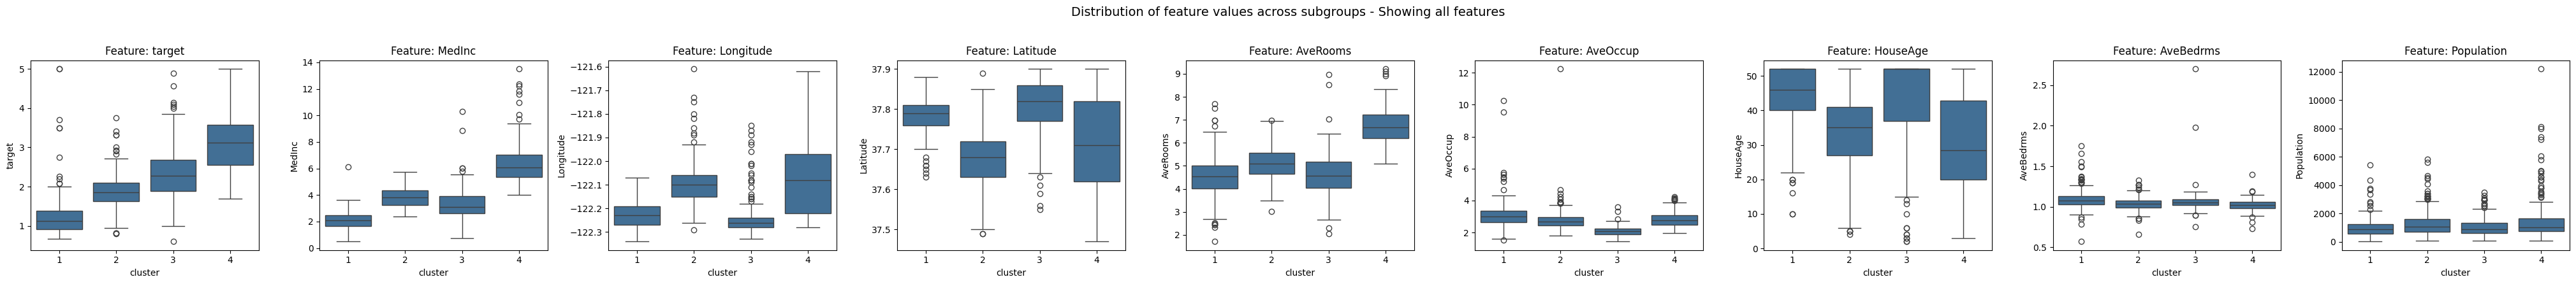

In [3]:
fgc = forest_guided_clustering(
    estimator=rf_housing, 
    X=data_housing_train, 
    y='MedHouseVal', 
    clustering_distance_metric=DistanceRandomForestProximity(), 
    clustering_strategy=ClusteringKMedoids(method="fasterpam"),
    JI_discart_value=0.9
)
feature_importance = forest_guided_feature_importance(
    X=data_housing_train, 
    y='MedHouseVal', 
    cluster_labels=fgc.cluster_labels,
    model_type=fgc.model_type,
)
plot_forest_guided_decision_paths(
    data_clustering=feature_importance.data_clustering,
    model_type=fgc.model_type,
    num_cols=9,
    heatmap=False
)

We then evaluate the model's performance on a separate **test set**, consisting of the **next 1,000 samples** from the California Housing dataset. As expected, the model's performance **decreases** slightly on the test set compared to the training set, indicating potential overfitting or the presence of patterns in the training data that do not generalize.

In [4]:
data_housing_test = data_housing.iloc[6000:7000]
data_housing_test.reset_index(inplace=True, drop=True)
X_housing_test = data_housing_test.loc[:, data_housing_test.columns != 'MedHouseVal']
y_housing_test = data_housing_test.MedHouseVal

print(f'Test Set R^2 of prediction model: {round(rf_housing.score(X_housing_test, y_housing_test),3)}')

Test Set R^2 of prediction model: 0.562


To explore this further, we apply FGC **again on the test data**, using the same trained Random Forest model. This allows us to assess which of the patterns discovered in the training data persist in the unseen data and which do not.

Using a sample size of 80.0 % of the input data.
Using range k = (4, 4) to optimize k.


Optimizing k: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]



Clustering Evaluation Summary:
 k    Score  Stable  Mean_JI                               Cluster_JI
 4 0.415823    True    0.963 {1: 0.962, 2: 0.979, 3: 0.985, 4: 0.927}


100%|██████████| 8/8 [00:00<00:00, 862.45it/s]


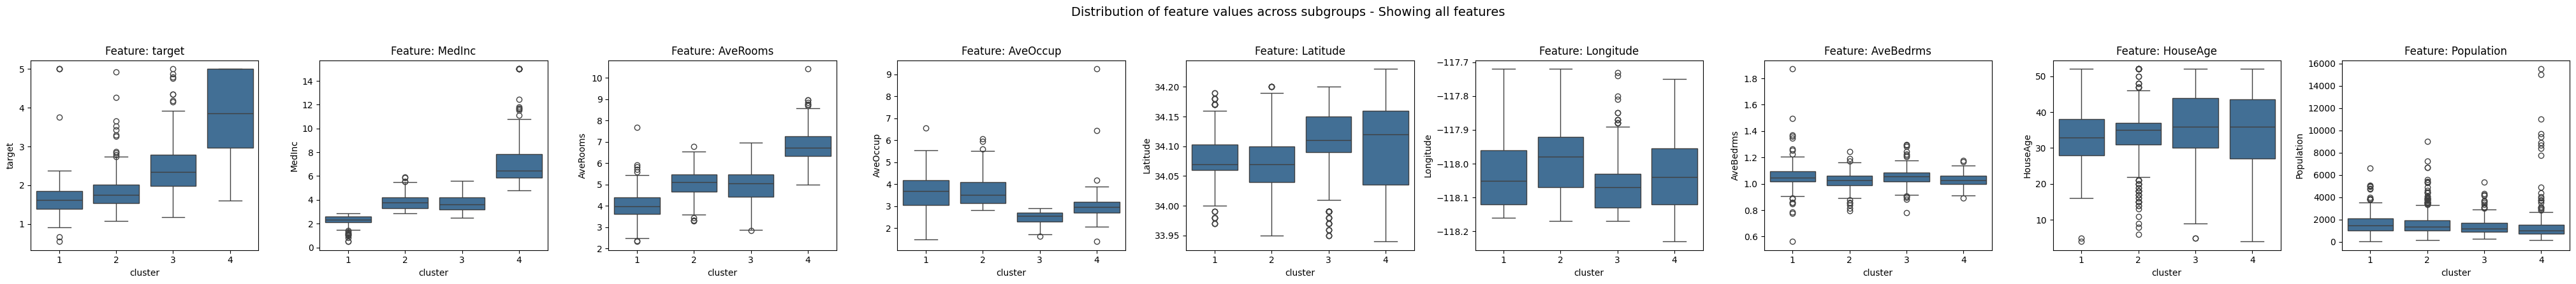

In [5]:
fgc = forest_guided_clustering(
    k=4,
    estimator=rf_housing, 
    X=data_housing_test, 
    y='MedHouseVal', 
    clustering_distance_metric=DistanceRandomForestProximity(), 
    clustering_strategy=ClusteringKMedoids(method="fasterpam"),
    JI_discart_value=0.9
)
feature_importance = forest_guided_feature_importance(
    X=data_housing_test, 
    y='MedHouseVal', 
    cluster_labels=fgc.cluster_labels,
    model_type=fgc.model_type,
)
plot_forest_guided_decision_paths(
    data_clustering=feature_importance.data_clustering,
    model_type=fgc.model_type,
    num_cols=9,
    heatmap=False
)

## 🏁 Conclusions

By comparing the **feature-wise distribution plots** from the FGC runs on both the training and test sets, we observe both **commonalities and differences**:

* Features like `MedInc`, `AveRooms`, and `AveOccup` exhibit **consistent trends** across clusters in both datasets.
* In contrast, features such as `Latitude`, `Longitude`, and `HouseAge` show **weaker or inconsistent trends** in the test set, especially for clusters representing intermediate housing values.

These shifts suggest that the model may have learned **patterns specific to the training data**, particularly those involving geolocation and house age, which **do not generalize** well. This not only explains the **drop in test performance**, but also highlights the **value of FGC** for testing the **stability of feature-cluster relationships** across datasets.